# Simple EDA & Baseline Data Preparation
**Target**: Finding key features and preparation of raw data set.

### Bussines and technical context
Before proceeding with advanced Feature Engineering, it is crucial to benchmark how the models (XGBoost & Neural Networks) perform on basic, raw data. This notebook is **control group** during experiment.

Scope of work in this notebook:
1. Data integrity check,
2. Feature selection,
3. Data export.

### Selected features
For the baseline variant, following features were sellected:
- Demographic: `Country`, `Gender`, `Age`
- Banking: `Balance`, `Products_Number`, `Active_Member`
- Target: `Churn` (0 = Client stays, 1 = Exited)

In [11]:
import pandas as pd
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [12]:
df = pd.DataFrame(pd.read_csv("../data/Bank Customer Churn Prediction.csv"))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [14]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [16]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Correlation analysis
**Goal** : Finding linear relationships between numerical features and the target variable.

We calculated the **Pearson correlation coefficient** for all numeric features.

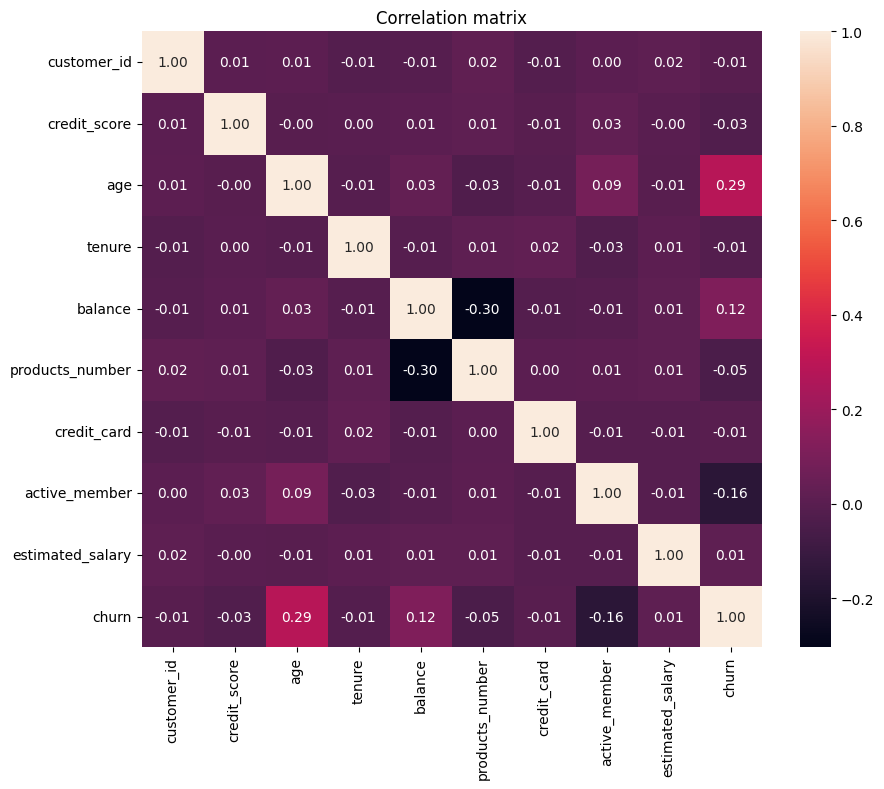

In [17]:
df_numeric =  df.select_dtypes(include=['number'])
corr_matrix=df_numeric.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)
plt.title("Correlation matrix")
plt.show()

Analysis identified only three features with meaningful linear correlation: `age`, `balance`, and `active_Member`.
* **Feature Interaction:** Although a correlation exists between `products_number` and `balance`, it is not strong enough to negatively affect the Neural Network's training stability.

### Statistical significance analysis (Chi-Square Test)
**Goal:** Verification of statistical significant relationship of categorical features `gender`, `county` and target variable `churn`.

**Methodology**
* **Null Hyphotesis $H_0$:** There is no relationship between the feature and customer churn.
* **Alternative Hyphotesis $H_1$:** There is a relationship between the feature and customer churn.

In [18]:
variables = ["country", "gender"]
target = "churn"
p = lambda p: p if p >= 0.05 else 0.0
for v in variables:
    tab = pd.crosstab(df[v], df[target])
    chi, p_val, dof, expected = stats.chi2_contingency(tab)
    print(f"Dla {v} p-value wynosi: {p(p_val)}.")


Dla country p-value wynosi: 0.0.
Dla gender p-value wynosi: 0.0.


**Conclusion**
For both `country` and `gender` the p-value is lower than 0.05.
- **Rejection of Null Hypothesiss**
- **Insights**
  - **Geography matters** - There are specifc customers behaviours in different countries.
  - **Gender matters** -  There is notable difference in customer behaviour between men and women. 

### Final Feature Selection
* **Strong Indicators:** `Country`, `Gender`, `Age`, `Balance`, and `Active_Member` were selected due to their statistically significant relationships with the target variable `Churn`.
* **Non-Linear Feature:** `Products_Number` was included despite having a linear correlation close to 0.
    * *Reasoning:* Low Pearson correlation only rules out linear trends. We hypothesize that product count has a **non-linear impact**, which our chosen models (XGBoost & MLP) are designed to detect.

In [19]:
to_be_exported = ["country", "gender", "age", "balance", "active_member", "products_number", "churn"]
df_final = df[to_be_exported]
df_final.head()

,country,gender,age,balance,active_member,products_number,churn
0,France,Female,42,0.00,1,1,1
1,Spain,Female,41,83807.86,1,1,0
2,France,Female,42,159660.80,0,3,1
3,France,Female,39,0.00,0,2,0
4,Spain,Female,43,125510.82,1,1,0


In [20]:
df_final.to_csv("../data/data_simple_eda.csv", index=False)